In [147]:
import requests, re
from bs4 import BeautifulSoup as bs
import pandas as pd
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
import time, random
from urllib.request import urlopen
import urllib.parse
import numpy as np
from IPython.display import display
import datetime
import Levenshtein as lev
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score
import statsmodels.api as sm

The goal of this project is to predict a book's demand on Overdrive (an ebook hosting service for public libraries) based on the book's publication date, popularity, author reputation, and numerous other factors.

Import data set for books for which data exist for number of people who requested the book or have it checked out.

In [50]:
# df = pd.read_csv('Figures/merged_df_lev_cleaned.csv', index_col = 0)
df = pd.read_csv('Figures/test.csv', index_col = 0)
df = df[df['Library copies'] != 'info unavailable']

In [51]:
df.loc[df['Library copies'] == 'Always available', 'Library copies'] = float('inf')

In [52]:
df = df[(df['Library copies'] != float('inf')) & (df['title'] != '-1')]

## Cleaning
Make sure the book on Overdrive and the one on Goodreads match by measuring the Levenshtein ratio between the books' authors.

In [53]:
df = df[(df.LevScore_updated > 0.43) & (df.author_ratings != -1.0) ]

Clean up data to convert it to ints and floats from the raw form it came in from the websites.

In [54]:
df['People waiting per copy'] = df['People waiting per copy'].apply(lambda x: x.replace('<', '')).astype('int')

In [55]:
df[['Library copies', 'People waiting in total']] = df[['Library copies', 'People waiting in total']].astype('int').copy()

In [56]:
# df['demand'] = np.nan
df['demand'] = df.apply(lambda x: x['Library copies'] + x['People waiting in total'], axis=1)

Normalize cumulative columns by year to correct for older authors having more reviews than younger authors despite younger authors potentially being more popular. Presumably, older authors will have had more time to accumulate reviews than younger authors.

In [88]:
norm_columns = ['number of ratings', 'author_ratings', 'author_num_reviews', 'author_distinct_works']

In [89]:
for col in norm_columns:
    new_col = col + '_norm'
    df[new_col] = df.apply(lambda x: x[col] / (2022 - x.year_published), axis=1)

Multiply number of stars by number of reviews to get a sense of how popular a particular title is. High stars and low number of reviews would suggest a popular book in a niche category.

In [119]:
df['stars*num_ratings'] = df.apply(lambda x: x.stars * x['number of ratings'], axis=1)

In [132]:
df['stars*num_ratings_norm'] = df.apply(lambda x: x['stars*num_ratings'] / (2022-x['year_published']), axis=1)

In [131]:
df.to_csv('Figures/test.csv')

In [58]:
%matplotlib inline

Some basic visualizations to see if any patterns stand out.

## Demand is defined as number of people who have checked out a copy plus number of people on the waiting list if applicable.

Normalized means the data is divided by the number of years the book has been in print to correct for longevity.

Text(0, 0.5, 'Demand')

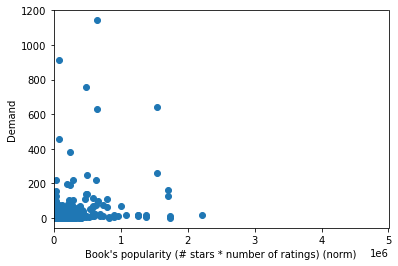

In [171]:
plt.scatter(df['stars*num_ratings_norm'], df['demand'])
ax = plt.gca()
ax.set_xlim(0,0.5E7)
plt.xlabel('Book\'s popularity (# stars * number of ratings) (norm)')
plt.ylabel('Demand')
# ax.set_ylim(0, 200)

There does not appear to be any meaningful relationship. What about with books published in the last 20 years?

In [117]:
df_recent = df[df.year_published > 2000]

Text(0, 0.5, 'Demand')

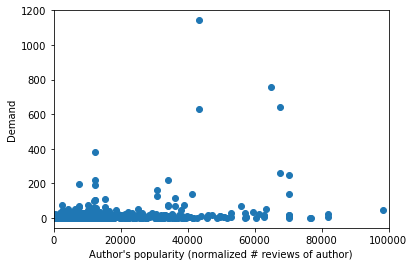

In [172]:
plt.scatter(df_recent['author_num_reviews_norm'], df_recent['demand'])
ax = plt.gca()
ax.set_xlim(0,1E5)
plt.xlabel('Author\'s popularity (normalized # reviews of author)')
plt.ylabel('Demand')
# ax.set_ylim(0, 200)

Perhaps something is happening with a handful of books that are in high demand but no obvious trend.

# Prediction
Book popularity likely obeys the power law (aka 80/20 rule). A handful of popular books get the majority of the demand. This may make it difficult to predict demand because it may not be possible to harvest enough data on the most popular titles on Overdrive simply because there aren't enough to do statistically meaningful calculations.

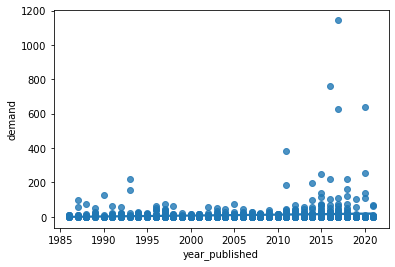

In [158]:
ax = sns.regplot(x="year_published", y="demand", data=df[df.year_published > 1985])

Year published seems to be the simplest predictor of demand. More recent books are more in demand.

Some linear regressions below. They don't appear to show anything meaningful.

In [163]:
#define response variable
x = df.year_published[df.year_published > 1985]

#define explanatory variable
y = df['demand'][df.year_published > 1985]

#add constant to predictor variables
x = sm.add_constant(x)

#fit linear regression model
model = sm.OLS(y, x, missing='drop').fit()

#view model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 demand   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     10.10
Date:                Sat, 15 Jan 2022   Prob (F-statistic):            0.00152
Time:                        16:26:16   Log-Likelihood:                -7010.9
No. Observations:                1310   AIC:                         1.403e+04
Df Residuals:                    1308   BIC:                         1.404e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -1067.8532    339.502     -3.

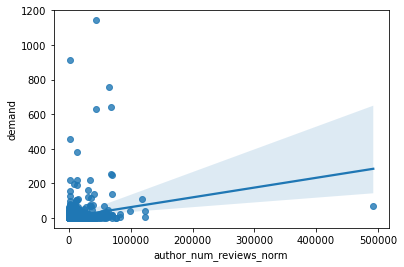

In [164]:
ax = sns.regplot(x="author_num_reviews_norm", y="demand", data=df)

In [165]:
#define response variable
x = df['author_num_reviews_norm']

#define explanatory variable
y = df['demand']

#add constant to predictor variables
x = sm.add_constant(x)

#fit linear regression model
model = sm.OLS(y, x, missing='drop').fit()

#view model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 demand   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     68.65
Date:                Sat, 15 Jan 2022   Prob (F-statistic):           2.27e-16
Time:                        16:27:33   Log-Likelihood:                -9555.3
No. Observations:                1798   AIC:                         1.911e+04
Df Residuals:                    1796   BIC:                         1.913e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [174]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1827 entries, 0 to 5267
Data columns (total 36 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id_number                   1827 non-null   float64
 1   title                       1827 non-null   object 
 2   author                      1827 non-null   object 
 3   author_url                  1827 non-null   object 
 4   stars                       1827 non-null   float64
 5   number of ratings           1827 non-null   float64
 6   url                         1827 non-null   object 
 7   is_series                   1827 non-null   object 
 8   year_published              1798 non-null   float64
 9   price                       1827 non-null   object 
 10  number of pages             1827 non-null   int64  
 11  is_movie                    1827 non-null   object 
 12  movie title                 1827 non-null   object 
 13  movie year                  1827 